In [1]:
from scipy.integrate import odeint, quad
import numpy as np
from gekko import GEKKO, chemical
import matplotlib.pyplot as plt


Objective: Max Cb 0.13828950457
Ua: 10000.0


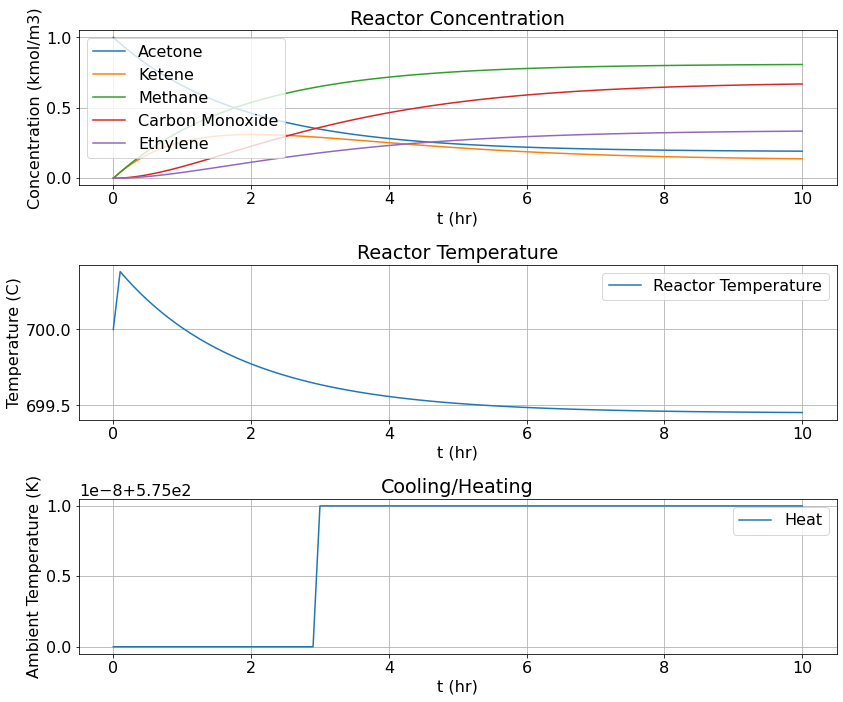

In [9]:
#---- Initialize Model ----#

m = GEKKO(remote=False)

nt = 101
tf = 10
m.time = np.linspace(0, tf, nt)

#---- Constants ----#

A_1 = m.Const(8.2e14)
Ea_1 = m.Const(2.845e5) # J/mol

A_2 = m.Const(1.7e17)
Ea_2 = m.Const(3.259e5) # J/mol

R = m.Const(8.314) # J/mol-K

Hf_a = m.Const(-2.4700e5) # kJ/kmol
Hf_b = m.Const(-47500)
Hf_c = m.Const(-74520)
Hf_d = m.Const(-1.1053e5)
Hf_e = m.Const(52510)

Ta_0 = 575 + 273.15

#---- Parameters ----#

Ta = m.MV(value=Ta_0, lb=300, ub=Ta_0 + 500, name='Ta')
Ta.STATUS = 1
Ta.DMAX = 50
Ta.DCOST = .1
Ta.FSTATUS = 0

Vr0 = 100

Vr = m.FV(value=Vr0, lb=50, ub=200)
Vr.STATUS = 0

v̇0 = 10

v̇ = m.FV(value=v̇0, lb=5, ub=50)
v̇.STATUS = 0
Ua = m.FV(1000, lb=1e4, ub=1e7)
Ua.STATUS = 0

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

#---- Initial Conditions ----#

Ca0 = 1 
Cb0 = 0
Cc0 = 0
Cd0 = 0
Ce0 = 0
T_0 = 700+273.15
x0 = np.array([Ca0, Cb0, Cc0, Cd0, Ce0, T_0])

#---- Inlet Conditions ----#
Ta_f = 700 + 273.15
Ca_f = 1 # kmol/m3

#---- Variables ----#
Ca = m.Var(value=Ca0, lb=0, name='Ca')
Cb = m.CV(value=Cb0, lb=0, name='Cb')
Cc = m.CV(value=Cc0, lb=0, name='Cc')
Cd = m.Var(value=Cd0, lb=0, name='Cd')
Ce = m.Var(value=Ce0, lb=0, name='Ce')
T = m.CV(value=T_0, lb=600+273.15, ub=800+273.15, name='T')


#CV tuning

Cb.STATUS = 1
Cb.FSTATUS = 1
Cb.TR_INIT = 1
Cb.TAU = 1
Cb.COST = 0
Cb.BIAS = 1e-1
DT = 0.5

Cc.STATUS = 0
Cc.FSTATUS = 0
Cc.TR_INIT = 1
Cc.TAU = 1.0
Cc.COST = 5

T.STATUS = 0
T.FSTATUS = 0
T.TR_INIT = 0
T.TAU = 1
T.COST = 0


#---- Intermediates ----#

A, B, C, D, E, F, G = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
Cp_a = m.Intermediate(A + B*(((C/T)**2*m.exp(C/T))/(m.exp(C/T) -1)**2) + D*(((E/T)**2*m.exp(E/T))/(m.exp(E/T) -1)**2) + F*(((G/T)**2*m.exp(G/T))/(m.exp(G/T) -1)**2))
A, B, C, D, E = [36940, 68650, 1490, 45240, 640]
Cp_b = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [33298, 79933, 2086.9, 41602, 991.96]
Cp_c = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [29108, 8773, 3085.1, 8455.3, 1538.2]
Cp_d = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [33380, 94790, 1596, 55100, 740.8]
Cp_e = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)


Na = m.Intermediate(Ca*Vr)
Nb = m.Intermediate(Cb*Vr)
Nc = m.Intermediate(Cc*Vr)
Nd = m.Intermediate(Cd*Vr)
Ne = m.Intermediate(Ce*Vr)

k_1 = m.Intermediate(A_1*m.exp(-Ea_1/(R*T))) # 1/hr
k_2 = m.Intermediate(A_2*m.exp(-Ea_2/(R*T)))

ra = m.Intermediate(k_1*Ca)
rb = m.Intermediate(k_2*Cb)

ΔHr_1 = m.Intermediate((   Hf_c + Hf_b - Hf_a) + (   Cp_c + Cp_b - Cp_a)*(T - 298.15))
ΔHr_2 = m.Intermediate((.5*Hf_e + Hf_d - Hf_b) + (.5*Cp_e + Cp_d - Cp_b)*(T - 298.15))

#---- Equations ----#

m.Equation(Ca.dt() == v̇*(Ca_f - Ca)/Vr - ra     )
m.Equation(Cb.dt() == v̇*(0    - Cb)/Vr + ra - rb)
m.Equation(Cc.dt() == v̇*(0    - Cc)/Vr + ra     )
m.Equation(Cd.dt() == v̇*(0    - Cd)/Vr +      rb)
m.Equation(Ce.dt() == v̇*(0    - Ce)/Vr +   .5*rb)
m.Equation(T.dt() ==  (Ua*(Ta - T) - (Ca_f*v̇)*Cp_a*(T - Ta_f) - ra*ΔHr_1 - rb*ΔHr_2/ \
                      (Na*Cp_a + Nb*Cp_b + Nc*Cp_c + Nd*Cp_d + Ne*Cp_e)))
           
# m.Equation(Cb*final > .10)
m.Obj(-Cb*final)
# m.Equation(Ca*final < .5)

m.options.IMODE = 6
m.options.NODES = 3
m.options.SOLVER = 3
m.options.CV_TYPE = 1
#m.open_folder()
m.solve(disp=False)


print('Objective: Max Cb', Cb.value[-1])
print('Ua:', Ua.value[-1])
# print('Objective: Min Cc', Cc.value[-1])
# print('Optimal Volume:', Vr.value[0])
# print('Volumetric Flow Rate:', v̇.value)

def plot():

    plotsize=(12,10)
    fontsize=16

    plt.figure(1, figsize=plotsize)
    plt.rc('font', size=fontsize)

    plt.subplot(3,1,1)
    plt.plot(m.time, Ca.value, label='Acetone')
    plt.plot(m.time, Cb.value, label='Ketene')
    plt.plot(m.time, Cc.value, label='Methane')
    plt.plot(m.time, Cd.value, label='Carbon Monoxide')
    plt.plot(m.time, Ce.value, label='Ethylene')
    plt.xlabel('t (hr)')
    plt.ylabel('Concentration (kmol/m3)')
    plt.title('Reactor Concentration')
    plt.legend(loc='best')
    plt.grid()


    plt.subplot(3,1,2)
    plt.plot(m.time,np.array([T.value])[0,:]-273.15, label='Reactor Temperature')
    plt.xlabel('t (hr)')
    plt.ylabel('Temperature (C)')
    plt.legend(loc='best')
    plt.title('Reactor Temperature')
    plt.grid()


    plt.subplot(3,1,3)
    plt.plot(m.time,np.array([Ta.value])[0,:]-273.15, label='Heat')
    plt.xlabel('t (hr)')
    plt.ylabel('Ambient Temperature (K)')
    plt.legend(loc='best')
    plt.title('Cooling/Heating')
    plt.grid()
    
    plt.tight_layout()
plot()    

## Define Model

In [ ]:
def CSTR(y, t, Ca_f, Ta_f, v̇, Vr, Tc):
    Ca, Cb, Cc, Cd, Ce, T = y
    
    Na, Nb, Nc, Nd, Ne  = Ca*Vr, Cb*Vr, Cc*Vr, Cd*Vr, Ce*Vr
     
    
    def Cps(T, A, B, C, D, E, F, G):
        return A + B*(((C/T)**2*np.exp(C/T))/(np.exp(C/T) -1)**2) + D*(((E/T)**2*np.exp(E/T))/(np.exp(E/T) -1)**2) + F*(((G/T)**2*np.exp(G/T))/(np.exp(G/T) -1)**2)
    
    def Cp(T, A, B, C, D, E):
        return A + B*(C/T/(np.sinh(C/T)))**2 + D*(E/T/(np.cosh(E/T)))**2
    
    coeff_a = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
    coeff_b = [36940, 68650, 1490, 45240, 640]
    coeff_c = [33298, 79933, 2086.9, 41602, 991.96]
    coeff_d = [29108, 8773, 3085.1, 8455.3, 1538.2]
    coeff_e = [33380, 94790, 1596, 55100, 740.8]
    
    Cpa = Cps(T, *coeff_a)
    Cpb = Cp(T, *coeff_b)
    Cpc = Cp(T, *coeff_c)
    Cpd = Cp(T, *coeff_d)
    Cpe = Cp(T, *coeff_e)
 
    #---- Kinetics ----#
    
    def k(A, Ea, T):
        R = 8.314 # J/mole-K
        return A*np.exp(-Ea/(R*T))
    
    A_1 = 8.2e14
    Ea_1 = 2.845e5 # J/mol
    k_1_1 = k(A_1, Ea_1, T)
    
    A_2 = 1.7e17
    Ea_2 = 3.259e5 # J/mol
    k_2_1 = k(A_2, Ea_2, T)
    
    ra_1 = k_1_1*Ca
    rb_1 = k_2_1*Cb
    
    Ua = 1.64e7
    
    #---- Thermodynamics ----#
    
    Hr_a = -2.4700e5 # kJ/kmol
    Hr_b = -47500
    Hr_c = -74520
    Hr_d = -1.1053e5
    Hr_e = 52510
    
#     ΔHr_1 = lambda T: (Hr_c + Hr_b - Hr_a) + quad(lambda T: Cp(T, *coeff_c) + Cp(T, *coeff_b)\
#                                                  -Cps(T, *coeff_a), 298.15, T)[0]
#     ΔHr_2 = lambda T:(.5*Hr_e + Hr_d - Hr_b) + quad(lambda T: .5*Cp(T, *coeff_e) + Cp(T, *coeff_d)\
#                                                  -Cp(T, *coeff_b), 298.15, T)[0]
    
    ΔHr_1 = (Hr_c + Hr_b - Hr_a) + (Cpc + Cpb -Cpa)*(T - 298.15)
    ΔHr_2 = (.5*Hr_e + Hr_d - Hr_b) + (.5*Cpe + Cpd -Cpb)*(T - 298.15)
    
    #---- Equations ----#
    
    
    
    dCadt = v̇*(Ca_f - Ca)/Vr - ra_1
    dCbdt = v̇*(0    - Cb)/Vr + ra_1 - rb_1
    dCcdt = v̇*(0    - Cc)/Vr + ra_1
    dCddt = v̇*(0    - Cd)/Vr + rb_1
    dCedt = v̇*(0    - Ce)/Vr + .5*rb_1
    
#     dTdt = (Ua*(Tc - T) - (v̇*Ca_f)*Cpa(T)*(T - Ta_f) - ra_1*ΔHr_1(T) - rb_1*ΔHr_2(T))/\
#             (Na*Cpa(T) + Nb*Cpb(T) + Nc*Cpc(T) + Nd*Cpd(T) + Ne*Cpe(T))
    
    dTdt = (Ua*(Tc - T) - (v̇*Ca_f)*Cpa*(T - Ta_f) - ra_1*ΔHr_1 - rb_1*ΔHr_2)/\
            (Na*Cpa + Nb*Cpb + Nc*Cpc + Nd*Cpd + Ne*Cpe)
    
    
    equations = np.array([dCadt, dCbdt, dCcdt, dCddt, dCedt, dTdt])
    return equations

In [ ]:
%matplotlib

nt = 201
t = np.linspace(0, tf, nt)

Ca_arr = np.ones(len(t))
Cb_arr = np.zeros(len(t))
Cc_arr = np.zeros(len(t))
Cd_arr = np.zeros(len(t))
Ce_arr = np.zeros(len(t))
T_arr = np.ones(len(t)) * T_0
SP = np.ones(len(t))
Ta_u = np.ones(len(t)) * Ta_0

# Set point steps
SP[0:int((nt-1)/4)] = .1
SP[int((nt-1)/4):int((nt-1)/2)] = .2
SP[int((nt-1)/2):int((nt-1)*3/4)] = .05
SP[int((nt-1)*3/4):] = .125

# Create plot
plt.figure(figsize=(16,10))
plt.rc('font', size=20)
plt.ion()
plt.show()

# Simulate CSTR
for i in range(len(t)-1):
    # simulate one time period (0.05 sec each loop)
    ts = [t[i],t[i+1]]
    y = odeint(CSTR,x0,ts,args=(Ca_f,Ta_f,v̇0,Vr0,Ta_u[i]))
    # retrieve measurements
    Ca_arr[i+1] = y[-1][0]
    Cb_arr[i+1] = y[-1][1]
    Cc_arr[i+1] = y[-1][2]
    Cd_arr[i+1] = y[-1][3]
    Ce_arr[i+1] = y[-1][4]
    T_arr[i+1]  = y[-1][5]
    # insert measurement
    Cb.MEAS = Cb_arr[i+1]
    
    # solve MPC
    m.open_folder()
    m.solve(disp=True)

    Cb.SPHI = SP[i+1] + DT
    Cb.SPLO = SP[i+1] - DT

    # retrieve new Q value
    Ta_u[i+1] = Ta.NEWVAL
    # update initial conditions
    x0[0] = Ca_arr[i+1]
    x0[1] = Cb_arr[i+1]
    x0[2] = Cc_arr[i+1]
    x0[3] = Cd_arr[i+1]
    x0[4] = Ce_arr[i+1]
    x0[5] = T_arr[i+1]

    #%% Plot the results
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(t[0:i],Ta_u[0:i],'b--',linewidth=3)
    plt.ylabel('Temperature (K)')
    plt.legend(['Heating/Cooling'],loc='best')

    plt.subplot(3,1,2)
   # plt.plot(t[0:i],Ca_arr[0:i],'--',linewidth=3,label=r'$C_a$')
    plt.plot(t[0:i],Cb_arr[0:i],'y--',linewidth=3,label=r'$C_{b,meas}$')
   # plt.plot(t[0:i],Cc_arr[0:i],'g--',linewidth=3,label=r'$C_c$')
    #plt.plot(t[0:i],Cd_arr[0:i],'r--',linewidth=3,label=r'$C_d$')
    #plt.plot(t[0:i],Ce_arr[0:i],'m--',linewidth=3,label=r'$C_e$')
    plt.plot(t[0:i],SP[0:i],'k-',linewidth=3,label=r'$SP$')
    plt.ylabel(r'$C_b$ (mol/L)')
    plt.legend(loc='best')

    plt.subplot(3,1,3)
    plt.plot(t[0:i],T_arr[0:i],'b:',linewidth=3,label=r'$T$')
    
    plt.ylabel('T (K)')
    plt.xlabel('Time (hr)')
    plt.legend(loc='best')
    plt.draw()
    plt.tight_layout()
    plt.pause(0.01)

#%% Plot the results
# plotsize=(16,10)
# fontsize=16
# plt.figure(1, figsize=plotsize)
# plt.rc('font', size=fontsize)
# plt.subplot(3,1,1)
# plt.plot(t,Ta_u,'b--',linewidth=3)
# plt.ylabel('Temperature (K)')
# plt.legend(['Heating/Cooling'],loc='best')

# plt.subplot(3,1,2)
# plt.plot(t,Ca_arr,'--',linewidth=3,label=r'$C_a$')
# plt.plot(t,Cb_arr,'y--',linewidth=3,label=r'$C_{b,meas}$')
# plt.plot(t,Cc_arr,'g--',linewidth=3,label=r'$C_c$')
# plt.plot(t,Cd_arr,'r--',linewidth=3,label=r'$C_d$')
# plt.plot(t,Ce_arr,'m--',linewidth=3,label=r'$C_e$')
# plt.ylabel(r'$C_b$ (mol/L)')
# plt.legend(loc='best')

# plt.subplot(3,1,3)
# plt.plot(t,T_arr,'b:',linewidth=3,label=r'$T$')
# plt.plot(t,SP,'k-',linewidth=3,label=r'$SP$')
# plt.ylabel('T (K)')
# plt.xlabel('Time (hr)')
# plt.legend(loc='best')
# plt.tight_layout()
